<a href="https://colab.research.google.com/github/kmjohnson3/Intro-to-MRI/blob/master/NoteBooks/Spoiled_Gradient_Echo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spoiled Gradient Echo
In this notebook, we will explore the solutions to the Bloch equations for a spoiled gradient echo sequence. Recall the Spoiled Gradient echo has a timing diagram that looks like:

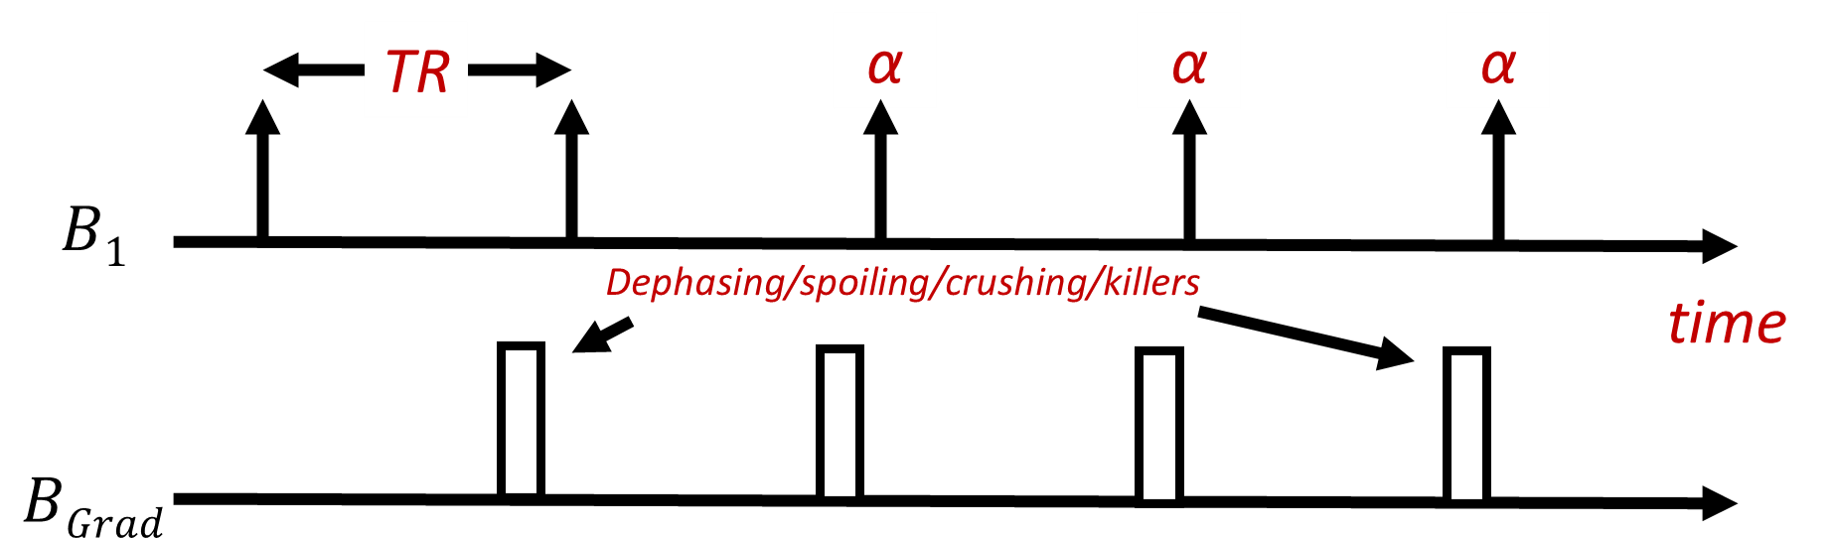

where $TR$ is the time between excitations with a flip angle of $\alpha$. To prevent the signal from carrying over from excitation to excitation, there is a gradinet applied to dephase the signal and the phase of the RF pulse is also incremented quadratically between excitations. The assumption of the solvers is that we can completely eliminate the transverse magnetization at the end of the TR gap.


In [1]:
# This is comment, Python will ignore this line

# Import libraries (load libraries which provide some functions)
%matplotlib inline
import numpy as np # array library
import math
import cmath

# For interactive plotting
from ipywidgets import interact, interactive, FloatSlider
from IPython.display import clear_output, display, HTML

# for plotting modified style for better visualization
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# Hit the play button to run this cell

# Import a solver

This will import the nutation solver we had before. There is one small change, we now have a special flag in the solver to "spoil" the magentization. We could alternatively simulate the dephasing process explicitly but this creates substantially more complexity. 

In [2]:
class Event:
  def __init__(self, excite_flip=0, excite_phase=0, recovery_time=0, spoil=False):
    self.excite_flip = excite_flip
    self.excite_phase = excite_phase
    self.recovery_time = recovery_time
    self.spoil = spoil

def bloch_nutation_solver( event_list, M0, T1, T2, freq ):

  #  Inputs:
  #    event_list -- Special structure with entries
  #             .excite_flip  flip angle of rotation
  #             .excite_phase phase of excite degrees
  #             .recovery_time time after excite to recover 
  #             .spoil (if 'true' this set the Mxy to zero at the recovery)
  #    T1         -- Longitudinal relaxation times (s)
  #    T2         -- Transverse relaxation times (s)
  #    Freq Offset-- Off center frequency in Hz
  #    M0         -- Initial state of magnetization (not equilibrium magnetization)
  #  Outputs:
  #    time -- Magnetization for each position in time
  #    BOutput -- Magnetic field for each position in time (interpolated)

  # Initialize
  count = 0;
  time = [0,];
  Mout = [M0,]

  M=M0;

  # Go through the event_list
  for event in event_list:
    
    theta = event.excite_phase * math.pi / 180
    alpha =  event.excite_flip * math.pi / 180
    T = event.recovery_time
    spoil = event.spoil
    
    # Excite
    Rz = np.array([[math.cos(theta), math.sin(theta), 0],
                    [-math.sin(theta), math.cos(theta), 0],
                    [0,  0, 1]]) 
    Rx = np.array([[1,0, 0],
                    [0, math.cos(alpha), math.sin(alpha)],
                    [0, -math.sin(alpha), math.cos(alpha)]])
    
    M = np.linalg.inv(Rz)@Rx@Rz@M 
    
    # Relaxation (Transverse)
    if spoil:
        Mxy = np.array(0 + 1j*0)
        Mx = 0
        My = 0
    else:
        Mxy = M[0] + 1j*M[1]
        Mxy = Mxy*cmath.exp( 2j*math.pi*freq*T)*math.exp(-T/T2)
        Mx = Mxy[0].real
        My = Mxy[0].imag
        
            
    # Relaxation (Longitudinal)
    Mz = M[2]
    Mz = 1 + (Mz - 1)*math.exp(-T/T1);
    
    # Put back into [Mx; My; Mz] vector
    M = np.array([[Mx], [My], [Mz[0]]])
    
    # Store for output
    time.append(time[-1]+T)
    Mout.append(M)

  Mout = np.array(Mout)
  return time, Mout
  

# Solution for SPGR
Now lets solve for an SPGR experiment. The key paramaters we have are

*   $TR$ sets the time between pulses, typically from 1 to 1000ms
*   $\alpha$ sets the flip angle, typically from $0^{\circ}$ to $90^{\circ}$
*   $TE$ would be the time after the excitation and would detrmine how much $T2^*$ weighting in the image



In [3]:
TR = 100e-3 
TE = 1e-3
alpha = 20 # in degrees

# Define this as a function to make this reusable
def make_excite_chain(TR, alpha):
  # Blank list of events
  event_list = []

  for excite_number in range(20):
    # Excite
    event_list.append( Event(excite_flip=alpha, excite_phase=0))

    # Gap (split into multiple gaps just to show recovery) 
    dt = TR / 100
    for pos in range(100):
        event_list.append( Event(recovery_time=dt))
      
    # Spoil
    event_list.append( Event(spoil=True))
  return event_list
  
def spgr_sim(T1, T2, freq, TR, alpha):

  # Simulate 
  M0 = np.array([[0],[0],[1.0]])
  event_list = make_excite_chain(TR, alpha)
  time, Mout = bloch_nutation_solver( event_list, M0, T1, T2, freq );

  plt.figure(figsize=(16,8))
  plt.plot(time,Mout[:,0], label=r'$M_x$')
  plt.plot(time,Mout[:,1], label=r'$M_y$')
  plt.plot(time,np.sqrt(Mout[:,1]**2+Mout[:,0]**2), '--', label=r'$M_y$')
  plt.plot(time,Mout[:,2], label=r'$M_z$')
  plt.ylabel('Magnetization [a.u.]')
  plt.xlabel('Time [s]')
  plt.legend()
  plt.show()


# Effect of parameters on the signal evolution
Below are plots of the signal evolution over. You can play around with paramaters to see if they change as you expect. Pay attention to the magnetization at the end of the chain.


In [4]:


w = interactive(spgr_sim, T1=(0.,5.), T2=(0.01, 0.5), TR=(0.,5.), freq=(-200,200), alpha=(0.0,90.0))
display(w)

interactive(children=(FloatSlider(value=2.5, description='T1', max=5.0), FloatSlider(value=0.255, description=…

# Steady State Signal

In the steady state, the magnetization will not change from excitation to excitation. In this state, the longitudinal magnetization just before the magnetization will aproach:

\begin{equation}
M_{z}^{-} = M_0 \frac{1 - e^{-TR/T1}}{1-cos(\alpha)e^{-TR/T1}}
\end{equation}

This signal will tip into the transverse plane by the flip angle $\alpha$:

\begin{equation}
M_{xy} = M_z\cdot sin(\alpha) \cdot e^{-TE/T2^*}
\end{equation}

Resulting in the total SPGR signal equation:

\begin{equation}
M_{z}^{-} = M_0 \cdot sin(\alpha) \cdot e^{-TE/T2^*} \frac{1 - e^{-TR/T1}}{1-cos(\alpha)e^{-TR/T1}}
\end{equation}

Below are two simulations investigating the effect of paramaters on the signal. The first compares the signals vs. T1 and the second compares the signal vs. flip angle.


In [5]:
def spgr_sim_steady_state( TR, alpha):

  # Simulate for a range of T1 values
  T1 = np.linspace(0.01, 5, 1000)

  # Steady state solution
  alpha_deg = alpha/180*math.pi
  Mz = (1-np.exp(-TR/T1))/(1-np.cos(alpha_deg)*np.exp(-TR/T1))
  Mxy = Mz*np.sin(alpha_deg)

  plt.figure(figsize=(16,8))
  plt.title(f'TR = {1e3*TR} ms, flip angle = {alpha} degrees')
  plt.plot(T1, Mxy, label=r'$M_{xy}$')
  plt.plot(T1, Mz, label=r'$M_z^{-}$')
  plt.ylabel('Magnetization [a.u.]')
  plt.xlabel('T1 [s]')
  plt.legend()
  plt.show()

w = interactive(spgr_sim_steady_state,  TR=(0.,5.), alpha=(0.0,90.0))
display(w)

interactive(children=(FloatSlider(value=2.5, description='TR', max=5.0), FloatSlider(value=45.0, description='…

In [6]:
def spgr_sim_steady_state( T1, TR):

  # Simulate for a range of T1 values
  alpha_deg = np.linspace(0., 90, 1000)
  alpha_rad = alpha_deg * math.pi / 180 

  # Steady state solution
  Mz = (1-np.exp(-TR/T1))/(1-np.cos(alpha_rad)*np.exp(-TR/T1))
  Mxy = Mz*np.sin(alpha_rad)

  plt.figure(figsize=(16,8))
  plt.title(f'T1 = {1e3*T1} ms, TR = {1e3*TR} ms')
  plt.plot(alpha_deg, Mz, label=r'$M_z^{-}$')
  plt.plot(alpha_deg, Mxy, label=r'$M_{xy}$')
  plt.ylabel('Magnetization [a.u.]')
  plt.xlabel(r'Flip angle [$^{\circ}$]')
  plt.legend()
  plt.show()

w = interactive(spgr_sim_steady_state, TR=FloatSlider(min=1e-3, max=100e-3, step=1e-3, value=10e-3),
                T1=FloatSlider(min=0.1, max=2, step=0.1, value=1))
display(w)

interactive(children=(FloatSlider(value=1.0, description='T1', max=2.0, min=0.1), FloatSlider(value=0.01, desc…